## Parsing unity VR log file using functions in the locproc module

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

In [2]:
# if you want to import files from the parent directory, please add the directory to the path:
#import sys, os, inspect
#currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
#parentdir = os.path.dirname(currentdir)
#sys.path.insert(0, os.path.dirname(parentdir))
#print(sys.path)

In [3]:
from unityvr.preproc import logproc
from unityvr.viz import viz

In [4]:
dirName = "../sample/"
fileName = "Log_2021-05-19_18-25-15_SS96_x_7f_f07_EB_panA2_t01.json"

dat = logproc.openUnityLog(dirName, fileName)

for i in range(5):
    print(dat[i]['frame'])
    print(json.dumps(dat[i], sort_keys=True, indent=4))

275.0
{
    "frame": 275.0,
    "frameAfterSplash": 275.0,
    "headerNotes": "~expid:SS96-x-7f_panA2 ~experiment:projectors on, panorama test, 144 Hz frame rate, SS96 > GCaMP7f in VK5 ~genotype:SS96-x-7f ~flyid:f07 ~sex:f ~age:6d ~notes:EB imaging ~trial:01                                                                                                                                            ",
    "timeSecs": 1.9807684421539307,
    "timeSecsAfterSplash": 1.9807684421539307
}
275.0
{
    "frame": 275.0,
    "frameAfterSplash": 275.0,
    "sessionParameters": [
        "timeoutSecs: 487",
        "backgroundCylinderTexture: C:\\Users\\labadmin\\Documents\\unityVR\\assets\\panoramas\\simpleFeatureTest\\A2_brightSpot.png"
    ],
    "timeSecs": 1.9807684421539307,
    "timeSecsAfterSplash": 1.9807684421539307
}
275.0
{
    "frame": 275.0,
    "frameAfterSplash": 275.0,
    "heightPixels": 720,
    "refreshRateHz": 144,
    "timeSecs": 1.9807684421539307,
    "timeSecsAfterSplash": 1.9

### Construct data object from log file
#### Extract header info

In [5]:
print(dat[0]['headerNotes'])
logproc.makeMetaDict(dat, fileName)

~expid:SS96-x-7f_panA2 ~experiment:projectors on, panorama test, 144 Hz frame rate, SS96 > GCaMP7f in VK5 ~genotype:SS96-x-7f ~flyid:f07 ~sex:f ~age:6d ~notes:EB imaging ~trial:01                                                                                                                                            


{'expid': 'SS96-x-7f_panA2',
 'experiment': 'projectors on, panorama test, 144 Hz frame rate, SS96 > GCaMP7f in VK5',
 'genotype': 'SS96-x-7f',
 'sex': 'f',
 'flyid': 'f07',
 'trial': 'trial01',
 'date': '2021-05-19',
 'time': '18-25-15',
 'notes': 'EB imaging'}

#### Pull out object positions as pandas dataframe

In [6]:
objDf = logproc.objDfFromLog(dat)
objDf.head()

,name,collider,px,py,pz,rx,ry,rz,sx,sy,sz
0,Fly/FlyCamera3/FlyCamera3Screen,MeshCollider,3.229198,-2.346149,-3.0495,0.0,0.0,306.0,5.8,1.0,9.5
1,Fly/FlyCamera2/FlyCamera2Screen,MeshCollider,3.229198,2.34615,-3.0495,0.0,0.0,234.0,5.800001,1.0,9.5
2,Fly/FlyCamera1/FlyCamera1Screen,MeshCollider,-1.233444,3.79615,-3.0495,0.0,0.0,162.0,5.8,1.0,9.5
3,BackgroundCylinder/default,NA,0.0,0.0,0.0,0.0,0.0,0.0,-5.8,5.8,1.95
4,Plane,MeshCollider,0.0,0.0,-10.0,0.0,0.0,0.0,50.0,50.0,1.0


#### Pull out fly position as pandas dataframe
Position in VR

In [7]:
posDf, ftDf, tsDf = logproc.timeseriesDfFromLog(dat)

/Users/haberkernh/Documents/GitHub/unityvr/unityvr/preproc/logproc.py:270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nidDf.imgfFilt[np.isfinite(nidDf.imgfsig)] = medfilt(nidDf.imgfsig[np.isfinite(nidDf.imgfsig)])


In [8]:
print(len(posDf))
posDf.head()

16886


,frame,time,dt,x,y,angle,dx,dy,dxattempt,dyattempt
0,300.0,0.000000,0.006938,-0.003107,-0.000850,347.793884,-0.003107,-0.000850,-0.003107,-0.000850
1,301.0,0.333333,0.333333,-0.004959,-0.002037,359.897400,-0.002061,-0.000768,-0.002061,-0.000768
2,302.0,0.338488,0.005155,-0.004408,-0.001198,16.944487,0.000553,0.000838,0.000553,0.000838
3,303.0,0.342010,0.003522,-0.004814,-0.001838,9.133280,-0.000202,-0.000731,-0.000202,-0.000731
4,304.0,0.343249,0.001239,-0.005201,-0.002103,6.724518,-0.000340,-0.000323,-0.000340,-0.000323


In [9]:
# Extract ball radius
matching = [s for s in dat if "ficTracBallRadius" in s]
ballRadius = matching[0]["ficTracBallRadius"]
print(ballRadius) # in decimeters

#conversion factor to cm
dc2cm = 10

0.04699999839067459


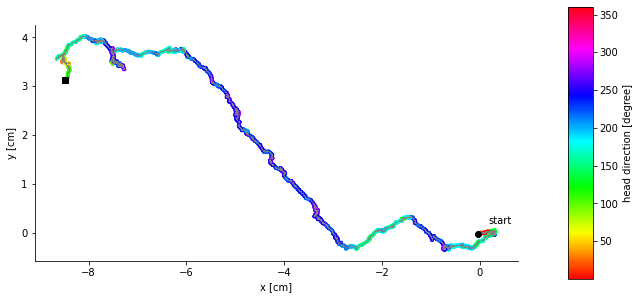

In [10]:
fig, axs = plt.subplots(1,2,figsize=(10,5), gridspec_kw={'width_ratios':[20,1]})
axs[0].plot(posDf.x*dc2cm,posDf.y*dc2cm,color='grey', linewidth=0.5)
cb = axs[0].scatter(posDf.x*dc2cm,posDf.y*dc2cm,s=5,c=posDf.angle, cmap='hsv')
axs[0].plot(posDf.x[0]*dc2cm,posDf.y[0]*dc2cm,'ok')
axs[0].text(posDf.x[0]*dc2cm+0.2,posDf.y[0]*dc2cm+0.2,'start')
axs[0].plot(posDf.x.values[-1]*dc2cm,posDf.y.values[-2]*dc2cm,'sk')
axs[0].set_aspect('equal')
axs[0].set_xlabel('x [cm]')
axs[0].set_ylabel('y [cm]')
viz.myAxisTheme(axs[0])
plt.colorbar(cb,cax=axs[1], label='head direction [degree]')

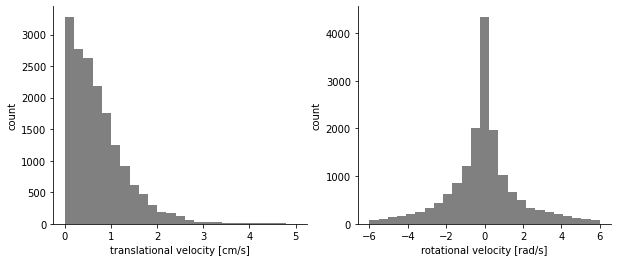

In [11]:
vt = np.hypot(posDf.dx*dc2cm, posDf.dy*dc2cm)/posDf.dt
vr = np.diff(posDf.angle*np.pi/180)/posDf.dt[1:]
fig, axs = plt.subplots(1,2,figsize=(10,4), gridspec_kw={'width_ratios':[1,1]})
axs[0].hist(vt,color='grey',bins=25, range=(0,5));
axs[0].set_xlabel('translational velocity [cm/s]')
axs[0].set_ylabel('count')
axs[1].hist(vr,color='grey',bins=25,range=(-6,6));
axs[1].set_xlabel('rotational velocity [rad/s]')
axs[1].set_ylabel('count')
for ax in axs:
    viz.myAxisTheme(ax)

Position based on Fictrac tracking

In [12]:
print(len(ftDf))
ftDf.head()

17111


,frame,ficTracTReadMs,ficTracTWriteMs,dx,dy,dz
0,300.0,0.0,0.0,-0.018430,-0.008164,-0.005159
1,300.0,1.0,6601685.0,-0.006297,0.004232,-0.009979
2,300.0,7.0,13203126.0,-0.004064,-0.013701,-0.026332
3,300.0,14.0,19804567.0,0.003868,0.002823,0.001051
4,300.0,20.0,26406292.0,-0.009425,0.000902,-0.034736


Photodiode signal and frame rate dataframe

In [13]:
print(len(tsDf))
tsDf.head()

117239


,frame,time,dt,pdsig,imgfsig,pdFilt,pdThresh,imgfFilt,imgfThresh,framestart,counts,frameinterp,timeinterp
0,300.0,0.000000,0.006938,NaN,NaN,NaN,0,NaN,0,0,1,300.000000,0.000000
1,301.0,0.333333,0.333333,0.011168,-0.001805,0.010844,0,-0.001805,0,1,1,301.000000,0.333333
2,301.0,0.333333,0.333333,0.010844,-0.001805,0.011168,0,-0.001805,0,0,1,301.022222,0.333448
3,301.0,0.333333,0.333333,0.011168,-0.002453,0.011168,0,-0.002453,0,0,1,301.044444,0.333562
4,301.0,0.333333,0.333333,0.011168,-0.002453,0.011168,0,-0.002453,0,0,1,301.066667,0.333677


In [14]:
framesDf = tsDf[['frame','time','dt']].drop_duplicates().reset_index(level=0)[['frame','time','dt']]

In [15]:
framesDf.head()

,frame,time,dt
0,300.0,0.000000,0.006938
1,301.0,0.333333,0.333333
2,302.0,0.338488,0.005155
3,303.0,0.342010,0.003522
4,304.0,0.343249,0.001239


Fictrac updates come in at a higher rate than the VR frame rate. Fictrac can also only run for a subset of the VR run time and therefore the number of frames in fictrac and vr dataframes may not match.

#### Frame rate

In [23]:
# Extract frame rate setting
matching = [s for s in dat if "refreshRateHz" in s]
forceframerate = matching[0]["refreshRateHz"]
print(forceframerate) # frame rate in Hz

144


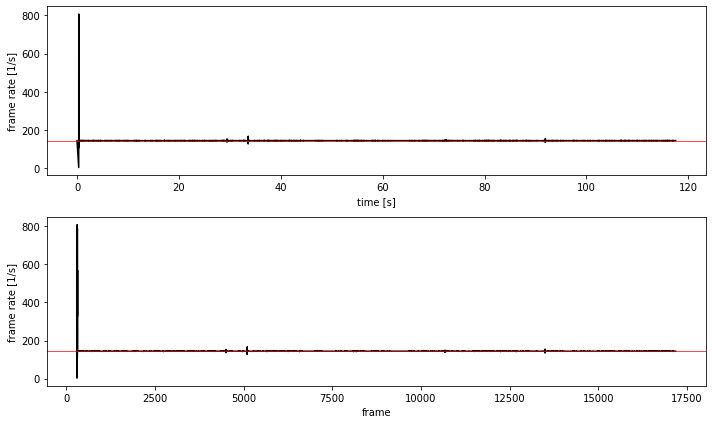

In [24]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
ax[0].plot(framesDf.time, 1/framesDf.dt, 'k')
ax[1].plot(framesDf.frame, 1/framesDf.dt, 'k')
ax[0].set_xlabel('time [s]')
ax[1].set_xlabel('frame');
for i in range(2):
    ax[i].axhline(forceframerate,0,1,color='r', linewidth=0.7)
    ax[i].set_ylabel('frame rate [1/s]')
fig.tight_layout()

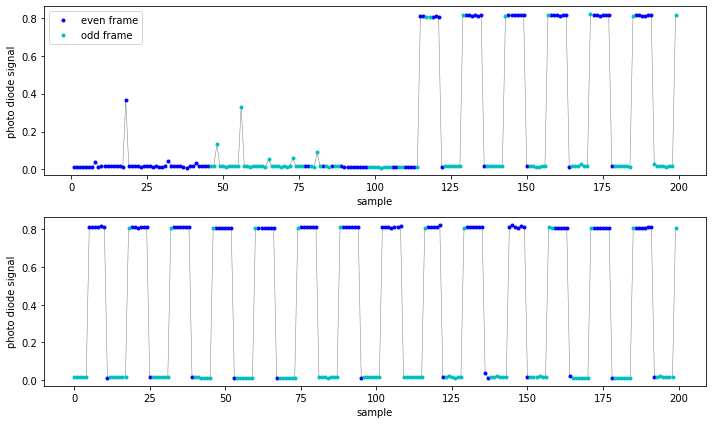

In [25]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
window = 200
for i, ts in enumerate([0,5000]):
    ax[i].plot(range(window),tsDf.pdsig[ts:ts+window],'-',color='grey',linewidth=0.5)
    
    even = tsDf[ts:ts+window][tsDf['frame'][ts:ts+window]%2==1]
    ax[i].plot(np.arange(window)[tsDf['frame'][ts:ts+window].values%2==1], even.pdsig, 'b.', label='even frame')
    
    odd = tsDf[ts:ts+window][tsDf['frame'][ts:ts+window]%2==0]
    ax[i].plot(np.arange(window)[tsDf['frame'][ts:ts+window].values%2==0], odd.pdsig, 'c.', label=
              'odd frame')
    
    ax[i].set_xlabel('time [s]')
    ax[i].set_ylabel('photo diode signal')
    ax[i].set_xlabel('sample');
ax[0].legend()
fig.tight_layout()

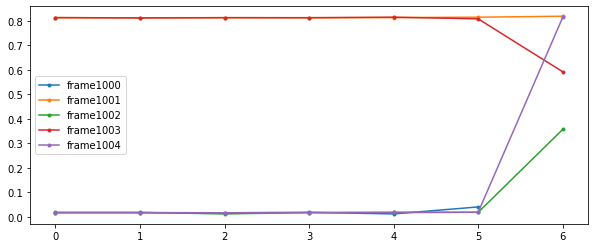

In [26]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
for f in range(1000,1005):
    sig = tsDf.query('frame == '+str(float(f)))
    ax.plot(range(len(sig.pdsig)), sig.pdsig, '.-',  label='frame{}'.format(f))
ax.legend()

Compute frame rate from photodiode signal

In [27]:
from scipy.signal import medfilt

tsDf["pdFilt"]  = tsDf.pdsig.values
tsDf.pdFilt[np.isfinite(tsDf.pdsig)] = medfilt(tsDf.pdsig[np.isfinite(tsDf.pdsig)])
tsDf["pdThresh"]  = 1*(np.asarray(tsDf.pdFilt>=0.2+np.nanmedian(tsDf.pdFilt.values)))

<ipython-input-27-69198de51145>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsDf.pdFilt[np.isfinite(tsDf.pdsig)] = medfilt(tsDf.pdsig[np.isfinite(tsDf.pdsig)])


Generate interpolated time

In [28]:
from scipy import interpolate

tsDf['framestart'] = np.hstack([0,1*np.diff(tsDf.time)>0])

tsDf['counts'] = 1
sampperframe = tsDf.groupby('frame').sum()[['time','dt','counts']].reset_index(level=0)
sampperframe['fs'] = sampperframe.counts/sampperframe.dt

frameStartIndx = np.hstack((0,np.where(tsDf.framestart)[0]))
frameStartIndx = np.hstack((frameStartIndx, frameStartIndx[-1]+sampperframe.counts.values[-1]-1))
frameIndx = tsDf.index.values

frameNums = tsDf.frame[frameStartIndx].values.astype('int')
frameNumsInterp = np.hstack((frameNums, frameNums[-1]+1))

timeAtFramestart = tsDf.time[frameStartIndx].values

#generate interpolated frames
frameinterp_f = interpolate.interp1d(frameStartIndx,frameNums)
tsDf['frameinterp'] = frameinterp_f(frameIndx)

timeinterp_f = interpolate.interp1d(frameStartIndx,timeAtFramestart)
tsDf['timeinterp'] = timeinterp_f(frameIndx)

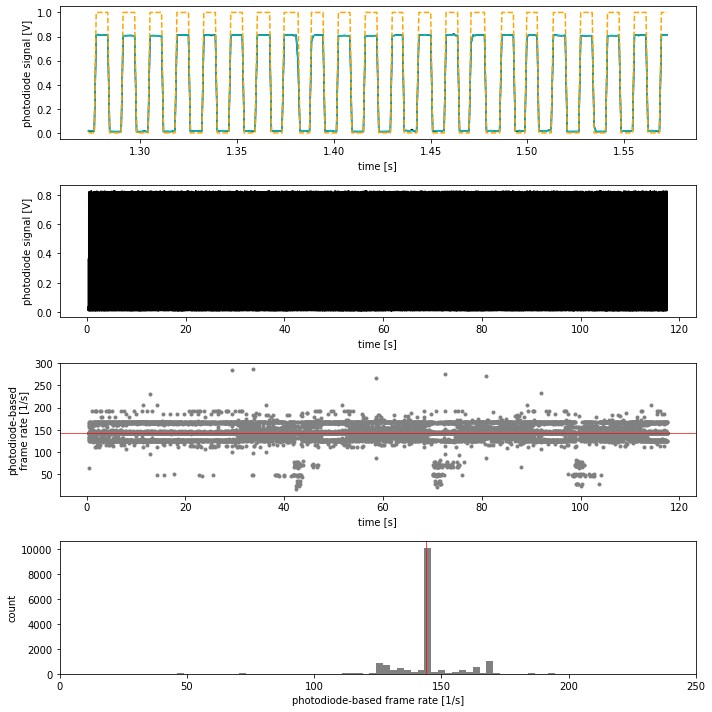

In [29]:
fig, ax = plt.subplots(4,1, figsize=(10,10))
ts = 1000
wind = 300
ax[0].plot(tsDf.timeinterp[ts:ts+wind], tsDf.pdsig[ts:ts+wind], 'k')
ax[0].plot(tsDf.timeinterp[ts:ts+wind], tsDf.pdFilt[ts:ts+wind], 'c')
ax[0].plot(tsDf.timeinterp[ts:ts+wind], tsDf.pdThresh[ts:ts+wind], '--',color='orange')
ax[0].set_ylabel('photodiode signal [V]')
ax[0].set_xlabel('time [s]')

pdChange = np.hstack((0,np.diff(tsDf.pdThresh)))
pdChangeT = tsDf.timeinterp.values[abs( pdChange )>0]

ax[1].plot(tsDf.timeinterp, tsDf.pdsig, 'k')
#ax[1].set_ylim(0,250)
ax[1].set_xlabel('time [s]')
ax[1].set_ylabel('photodiode signal [V]')

ax[2].plot(pdChangeT[1:], 1/np.diff(pdChangeT), '.', color='grey')
#ax[2].set_ylim(0,250)
ax[2].axhline(forceframerate,0,1,color='r', linewidth=0.7)
ax[2].set_xlabel('time [s]')
ax[2].set_ylabel('photodiode-based\nframe rate [1/s]')

ax[3].hist(1/np.diff(pdChangeT), 100, color='grey')
ax[3].set_xlim(0,250)
ax[3].axvline(forceframerate,0,1,color='r', linewidth=0.7)
ax[3].set_ylabel('count')
ax[3].set_xlabel('photodiode-based frame rate [1/s]')

fig.tight_layout()